In [1]:
%pylab inline
import os
import jax
import jax.numpy as np
import jax_cosmo as jc
import numpyro
import numpyro.distributions as dist

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Let's grab the data file
from astropy.io import fits
if not os.path.isfile('2pt_NG_mcal_1110.fits'):
    !wget http://desdr-server.ncsa.illinois.edu/despublic/y1a1_files/chains/2pt_NG_mcal_1110.fits

nz_source=fits.getdata('2pt_NG_mcal_1110.fits', 6)
nz_lens=fits.getdata('2pt_NG_mcal_1110.fits', 7)

# This is the effective number of sources from the cosmic shear paper
neff_s = [1.47, 1.46, 1.50, 0.73]
nzs_s = [jc.redshift.kde_nz(nz_source['Z_MID'].astype('float32'),
                            nz_source['BIN%d'%i].astype('float32'), 
                            bw=0.01,
                            gals_per_arcmin2=neff_s[i-1])
           for i in range(1,5)]
nzs_l = [jc.redshift.kde_nz(nz_lens['Z_MID'].astype('float32'),
                            nz_lens['BIN%d'%i].astype('float32'), bw=0.01)
        for i in range(1,6)]

# Define some ell range
ell = np.logspace(1, 3)

In [3]:
# Let's define our model using numpyro
# Papier https://arxiv.org/pdf/1708.01530.pdf  and desy1.py
def model():
    #  Cosmological params
    Omega_c = numpyro.sample('Omega_c', dist.Uniform(0.1, 0.9))
    sigma8 = numpyro.sample('sigma8', dist.Uniform(0.4, 1.0))
    Omega_b = numpyro.sample('Omega_b', dist.Uniform(0.03, 0.07))
    h = numpyro.sample('h', dist.Uniform(0.55, 0.91))
    n_s = numpyro.sample('n_s', dist.Uniform(0.87, 1.07)) 
    w0 = numpyro.sample('w0', dist.Uniform(-2.0, -0.33))

    # Intrinsic Alignment
    A = numpyro.sample('A', dist.Uniform(-5., 5.))
    eta = numpyro.sample('eta', dist.Uniform(-5., 5.))

    # linear galaxy bias
    bias = [numpyro.sample('b%d'%i, dist.Uniform(0.8, 3.0)) 
         for i in range(1,6)]
        
    # parameters for systematics
    m = [numpyro.sample('m%d'%i, dist.Normal(0.012, 0.023)) 
         for i in range(1,5)]
    dz1 = numpyro.sample('dz1', dist.Normal(0.001, 0.016)) 
    dz2 = numpyro.sample('dz2', dist.Normal(-0.019, 0.013)) 
    dz3 = numpyro.sample('dz3', dist.Normal(0.009, 0.011)) 
    dz4 = numpyro.sample('dz4', dist.Normal(-0.018, 0.022)) 
    dz = [dz1, dz2, dz3, dz4]
    
    # Now that params are defined, here is the forward model
    cosmo = jc.Cosmology(Omega_c=Omega_c, sigma8=sigma8, Omega_b=Omega_b,
                          h=h, n_s=n_s, w0=w0, Omega_k=0., wa=0.)
    
    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi, zmax=2.0) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)

    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in bias] 
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]

    cl, C = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, probes, 
                                                          f_sky=0.25, sparse=True)
    
    P = jc.sparse.to_dense(jc.sparse.inv(C))
    C = jc.sparse.to_dense(C)
    return cl, P, C

In [4]:
from numpyro.handlers import seed, trace, condition
# So, let's generate the data at the fiducial parameters
fiducial_model = condition(model,
    {'Omega_c':0.2545, 'sigma8':0.801, 'h':0.682, 'Omega_b':0.0485, 'w0':-1.,'n_s':0.971,
     'A':0.5,'eta':0.,
     'm1':0.0,'m2':0.0,'m3':0.0,'m4':0.0,
     'dz1':0.0,'dz2':0.0,'dz3':0.0,'dz4':0.0,
     'b1':1.2,'b2':1.4,'b3':1.6,'b4':1.8,'b5':2.0
      })

with seed(rng_seed=42):
    data, P, C = fiducial_model()

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5940: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


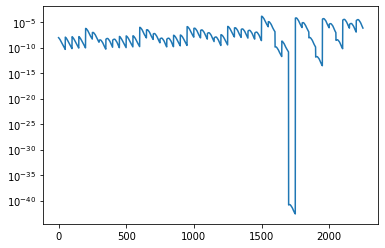

In [5]:
# This is our fake data vector
semilogy(data);

In [6]:
from numpyro.distributions.transforms import AffineTransform

def Uniform(name, min_value, max_value):
    """ Creates a Uniform distribution in target range from a base
    distribution between [-3, 3]
    """
    s = (max_value - min_value) / 6.
    return numpyro.sample(
            name,
            dist.TransformedDistribution(
                dist.Uniform(-3., 3.),
                AffineTransform(min_value + 3.*s, s),
            ),
        )

In [7]:
# Let's define our model using numpyro
# Papier https://arxiv.org/pdf/1708.01530.pdf  and desy1.py
def model():
    #  Cosmological params
    Omega_c = Uniform('Omega_c', 0.1, 0.9)
    sigma8 = Uniform('sigma8', 0.4, 1.0)
    Omega_b = Uniform('Omega_b', 0.03, 0.07)
    h = Uniform('h',0.55, 0.91)
    n_s = Uniform('n_s', 0.87, 1.07)
    w0 = Uniform('w0', -2.0, -0.33)

    # Intrinsic Alignment
    A = Uniform('A', -5., 5.)
    eta = Uniform('eta', -5., 5.)

    # linear galaxy bias
    bias = [Uniform('b%d'%i, 0.8, 3.0)
         for i in range(1,6)]
        
    # parameters for systematics
    m = [numpyro.sample('m%d'%i, dist.Normal(0.012, 0.023)) 
         for i in range(1,5)]
    dz1 = numpyro.sample('dz1', dist.Normal(0.001, 0.016)) 
    dz2 = numpyro.sample('dz2', dist.Normal(-0.019, 0.013)) 
    dz3 = numpyro.sample('dz3', dist.Normal(0.009, 0.011)) 
    dz4 = numpyro.sample('dz4', dist.Normal(-0.018, 0.022)) 
    dz = [dz1, dz2, dz3, dz4]
    
    # Now that params are defined, here is the forward model
    cosmo = jc.Cosmology(Omega_c=Omega_c, sigma8=sigma8, Omega_b=Omega_b,
                          h=h, n_s=n_s, w0=w0, Omega_k=0., wa=0.)
    
    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi, zmax=2.0) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)

    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in bias] 
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]

    cl = jc.angular_cl.angular_cl(cosmo, ell, probes).flatten()
    
    return numpyro.sample('cl', dist.MultivariateNormal(cl, 
                                                        precision_matrix=P,
                                                        covariance_matrix=C))

In [8]:
# Now we condition the model on obervations
observed_model = condition(model, {'cl': data})

In [9]:
from numpyro.infer.reparam import LocScaleReparam, TransformReparam

def config(x):
    if type(x['fn']) is dist.TransformedDistribution:
        return TransformReparam()
    elif type(x['fn']) is dist.Normal and ('decentered' not in x['name']):
        return LocScaleReparam(centered=0)
    else:
        return None

observed_model_reparam = numpyro.handlers.reparam(observed_model, config=config)

In [10]:
nuts_kernel = numpyro.infer.NUTS(observed_model_reparam,
                                 step_size=1e-1, 
                                 init_strategy=numpyro.infer.init_to_median,
                                 dense_mass=True,
                                 max_tree_depth=5)

In [11]:
mcmc = numpyro.infer.MCMC(nuts_kernel, 
                          num_warmup=200, 
                          num_samples=500,
                          num_chains=32,
                          chain_method='vectorized',
                          progress_bar=False)

In [12]:
# This takes about 4h on a TitanXp GPU
mcmc.run(jax.random.PRNGKey(42))

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5940: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5940: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/local/home/flanusse/.local/lib/python3.8/site-pac

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5940: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/local/home/flanusse/.local/lib/python3.8/site-packages/arviz/plots/traceplot.py:206: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (42), generating only 20 plots
  warnings.warn(


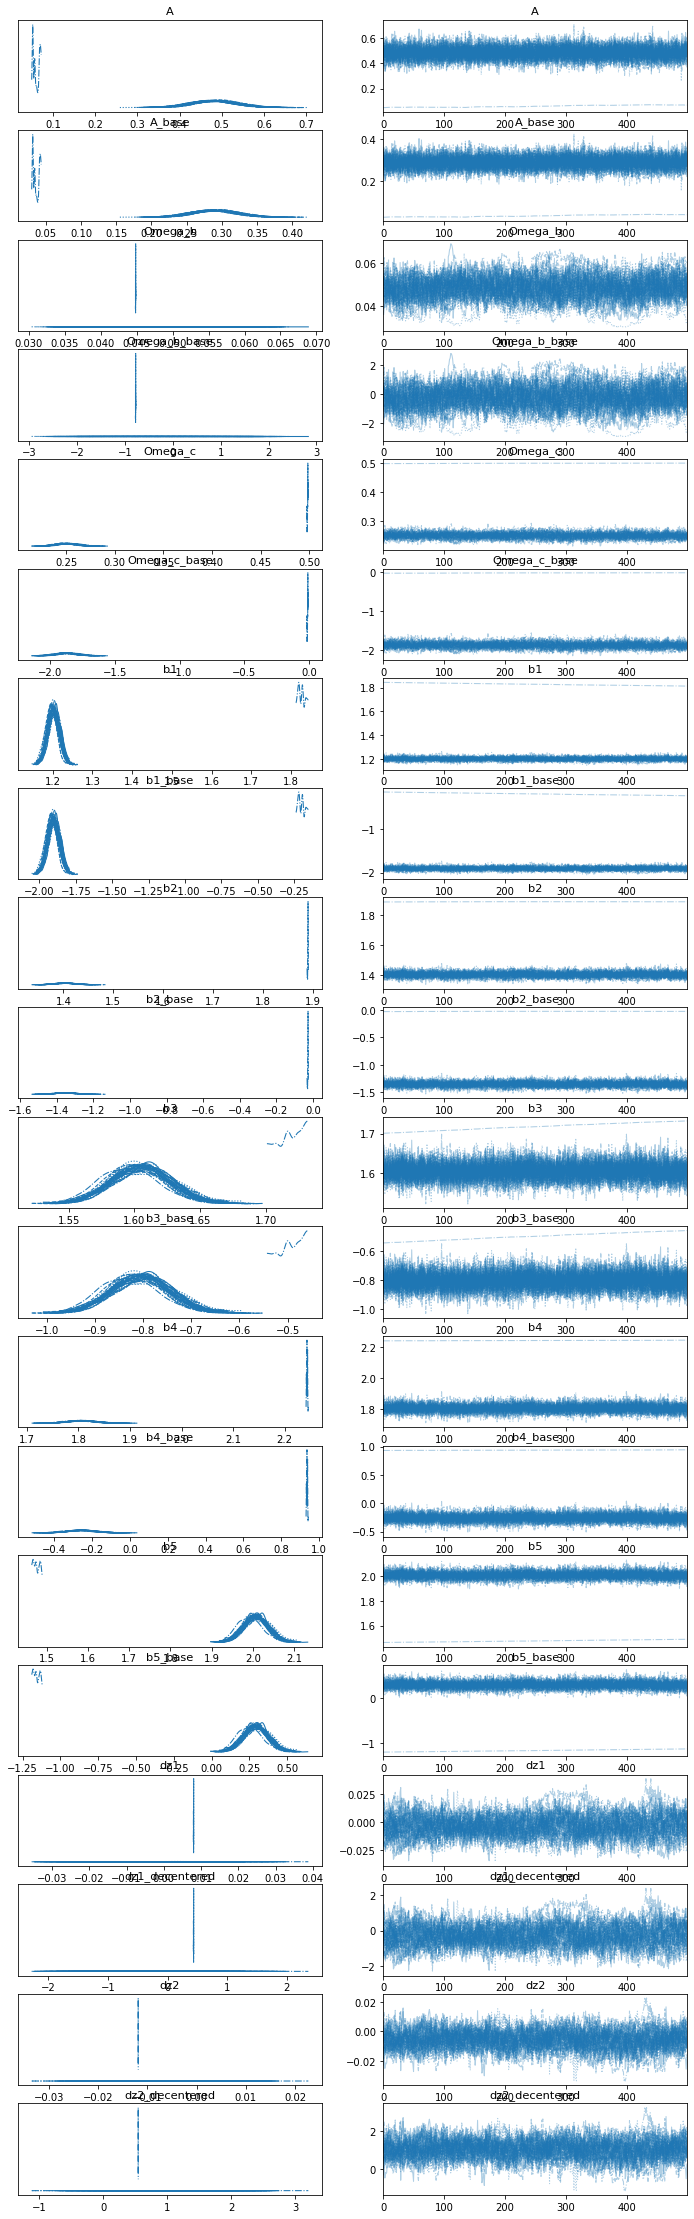

In [13]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

In [24]:
s = mcmc.get_samples()

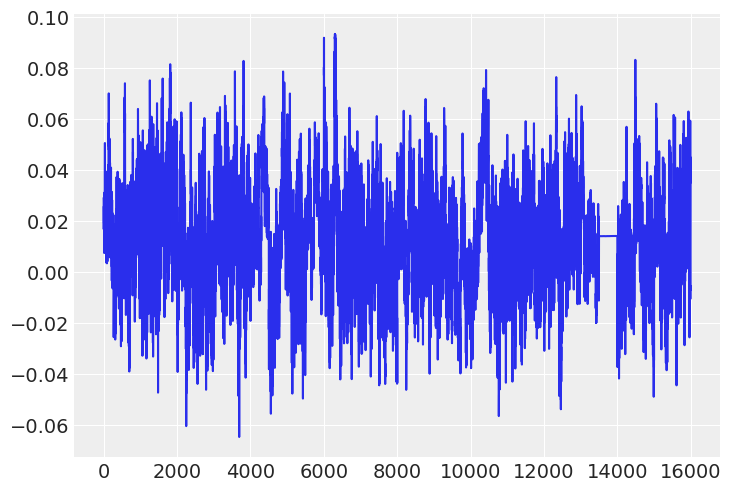

In [25]:
plot(s['m1'])

In [16]:
mcmc.print_summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
          A_base      0.28      0.05      0.29      0.24      0.35     23.81      1.78
    Omega_b_base     -0.28      0.86     -0.29     -1.61      1.20    161.56      1.15
    Omega_c_base     -1.81      0.33     -1.87     -2.01     -1.73     16.93      4.45
         b1_base     -1.85      0.30     -1.90     -1.98     -1.83     16.32      7.56
         b2_base     -1.31      0.24     -1.35     -1.44     -1.26     16.75      4.86
         b3_base     -0.80      0.08     -0.80     -0.92     -0.70     36.10      1.37
         b4_base     -0.22      0.22     -0.25     -0.39     -0.13     17.83      3.18
         b5_base      0.25      0.26      0.29      0.14      0.44     17.63      3.36
  dz1_decentered     -0.25      0.62     -0.26     -1.25      0.74    170.17      1.17
  dz2_decentered      1.02      0.52      1.02      0.20      1.88    276.28      1.11
  dz3_decentered     -0.82      0.55     -

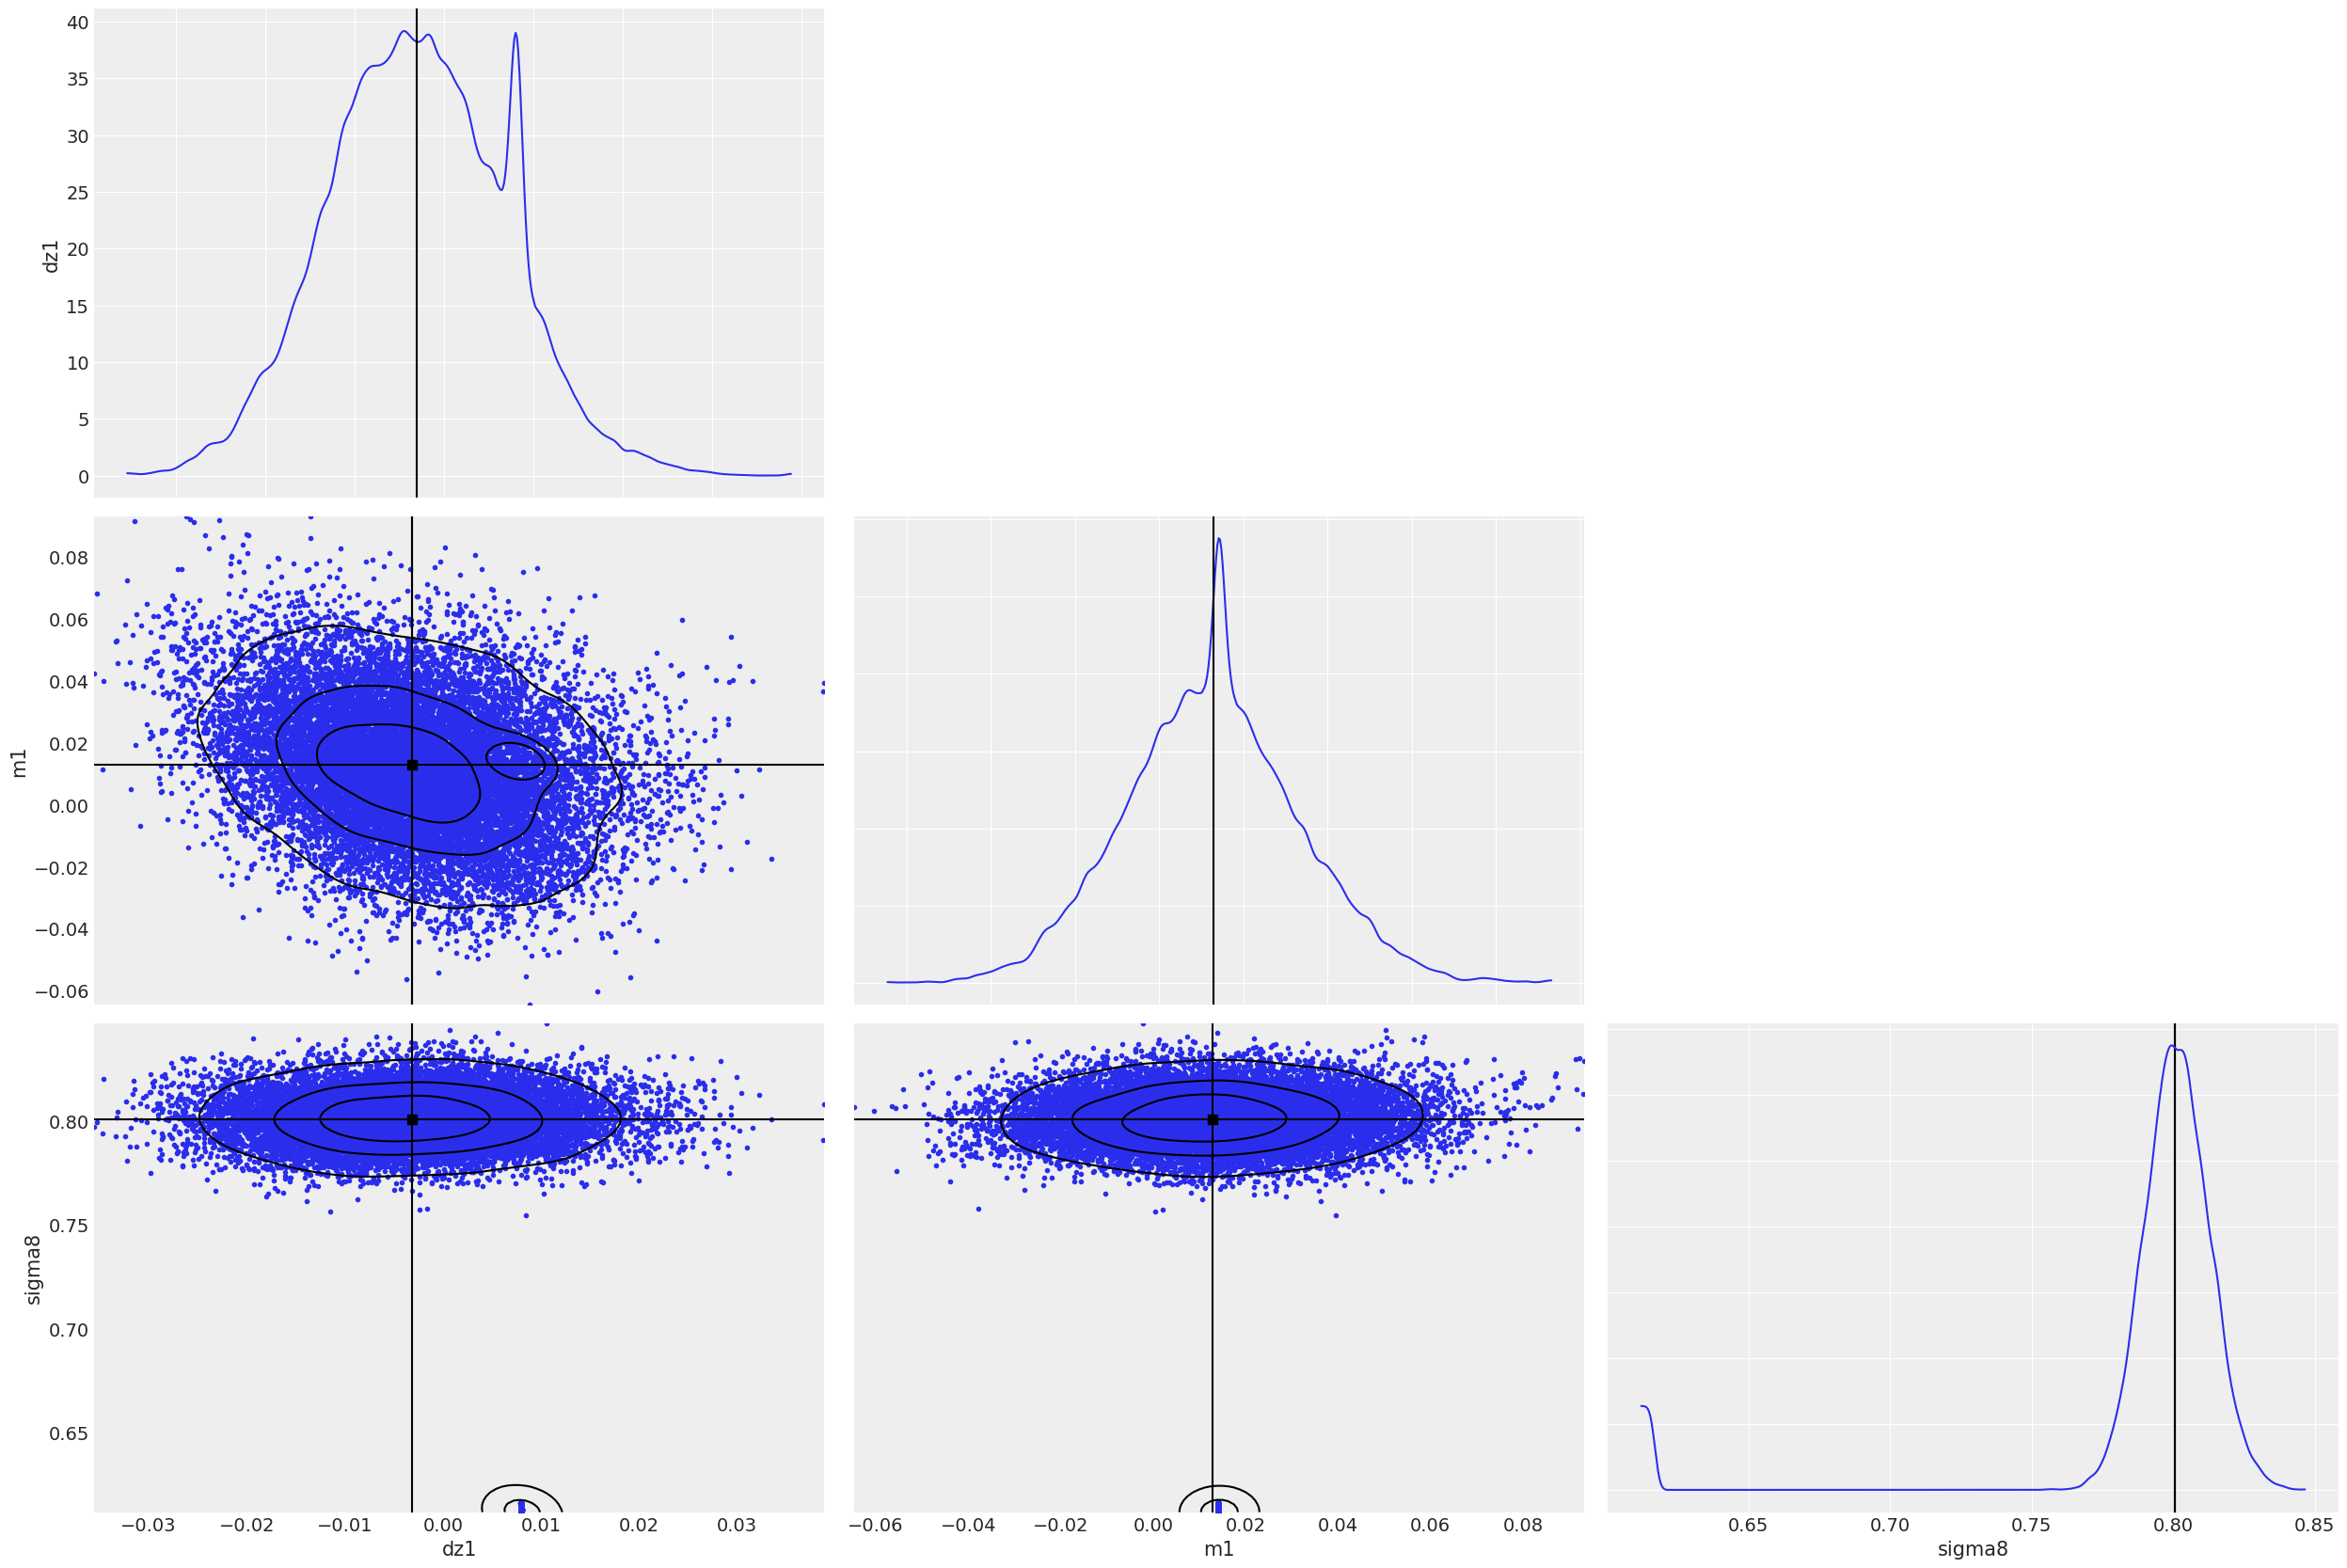

In [17]:
import arviz as az

az.style.use("arviz-darkgrid")

az.plot_pair(
    s,
    kind=["scatter", "kde"],
    var_names=['dz1', 'm1', 'sigma8'],
    kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Blues"},
    },
    marginals=True,
    point_estimate="median",
);

In [26]:
m = s['sigma8'] > 0.65

In [27]:
s = {k:s[k][m] for k in s.keys()}

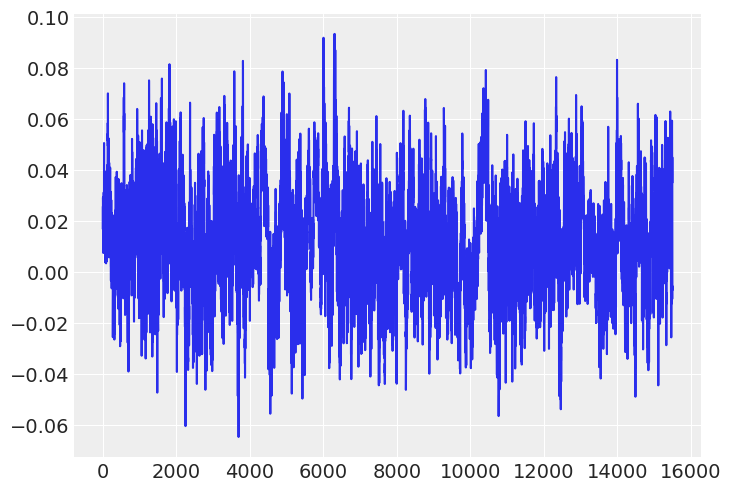

In [28]:
plot(s['m1']); print(len(s[]))

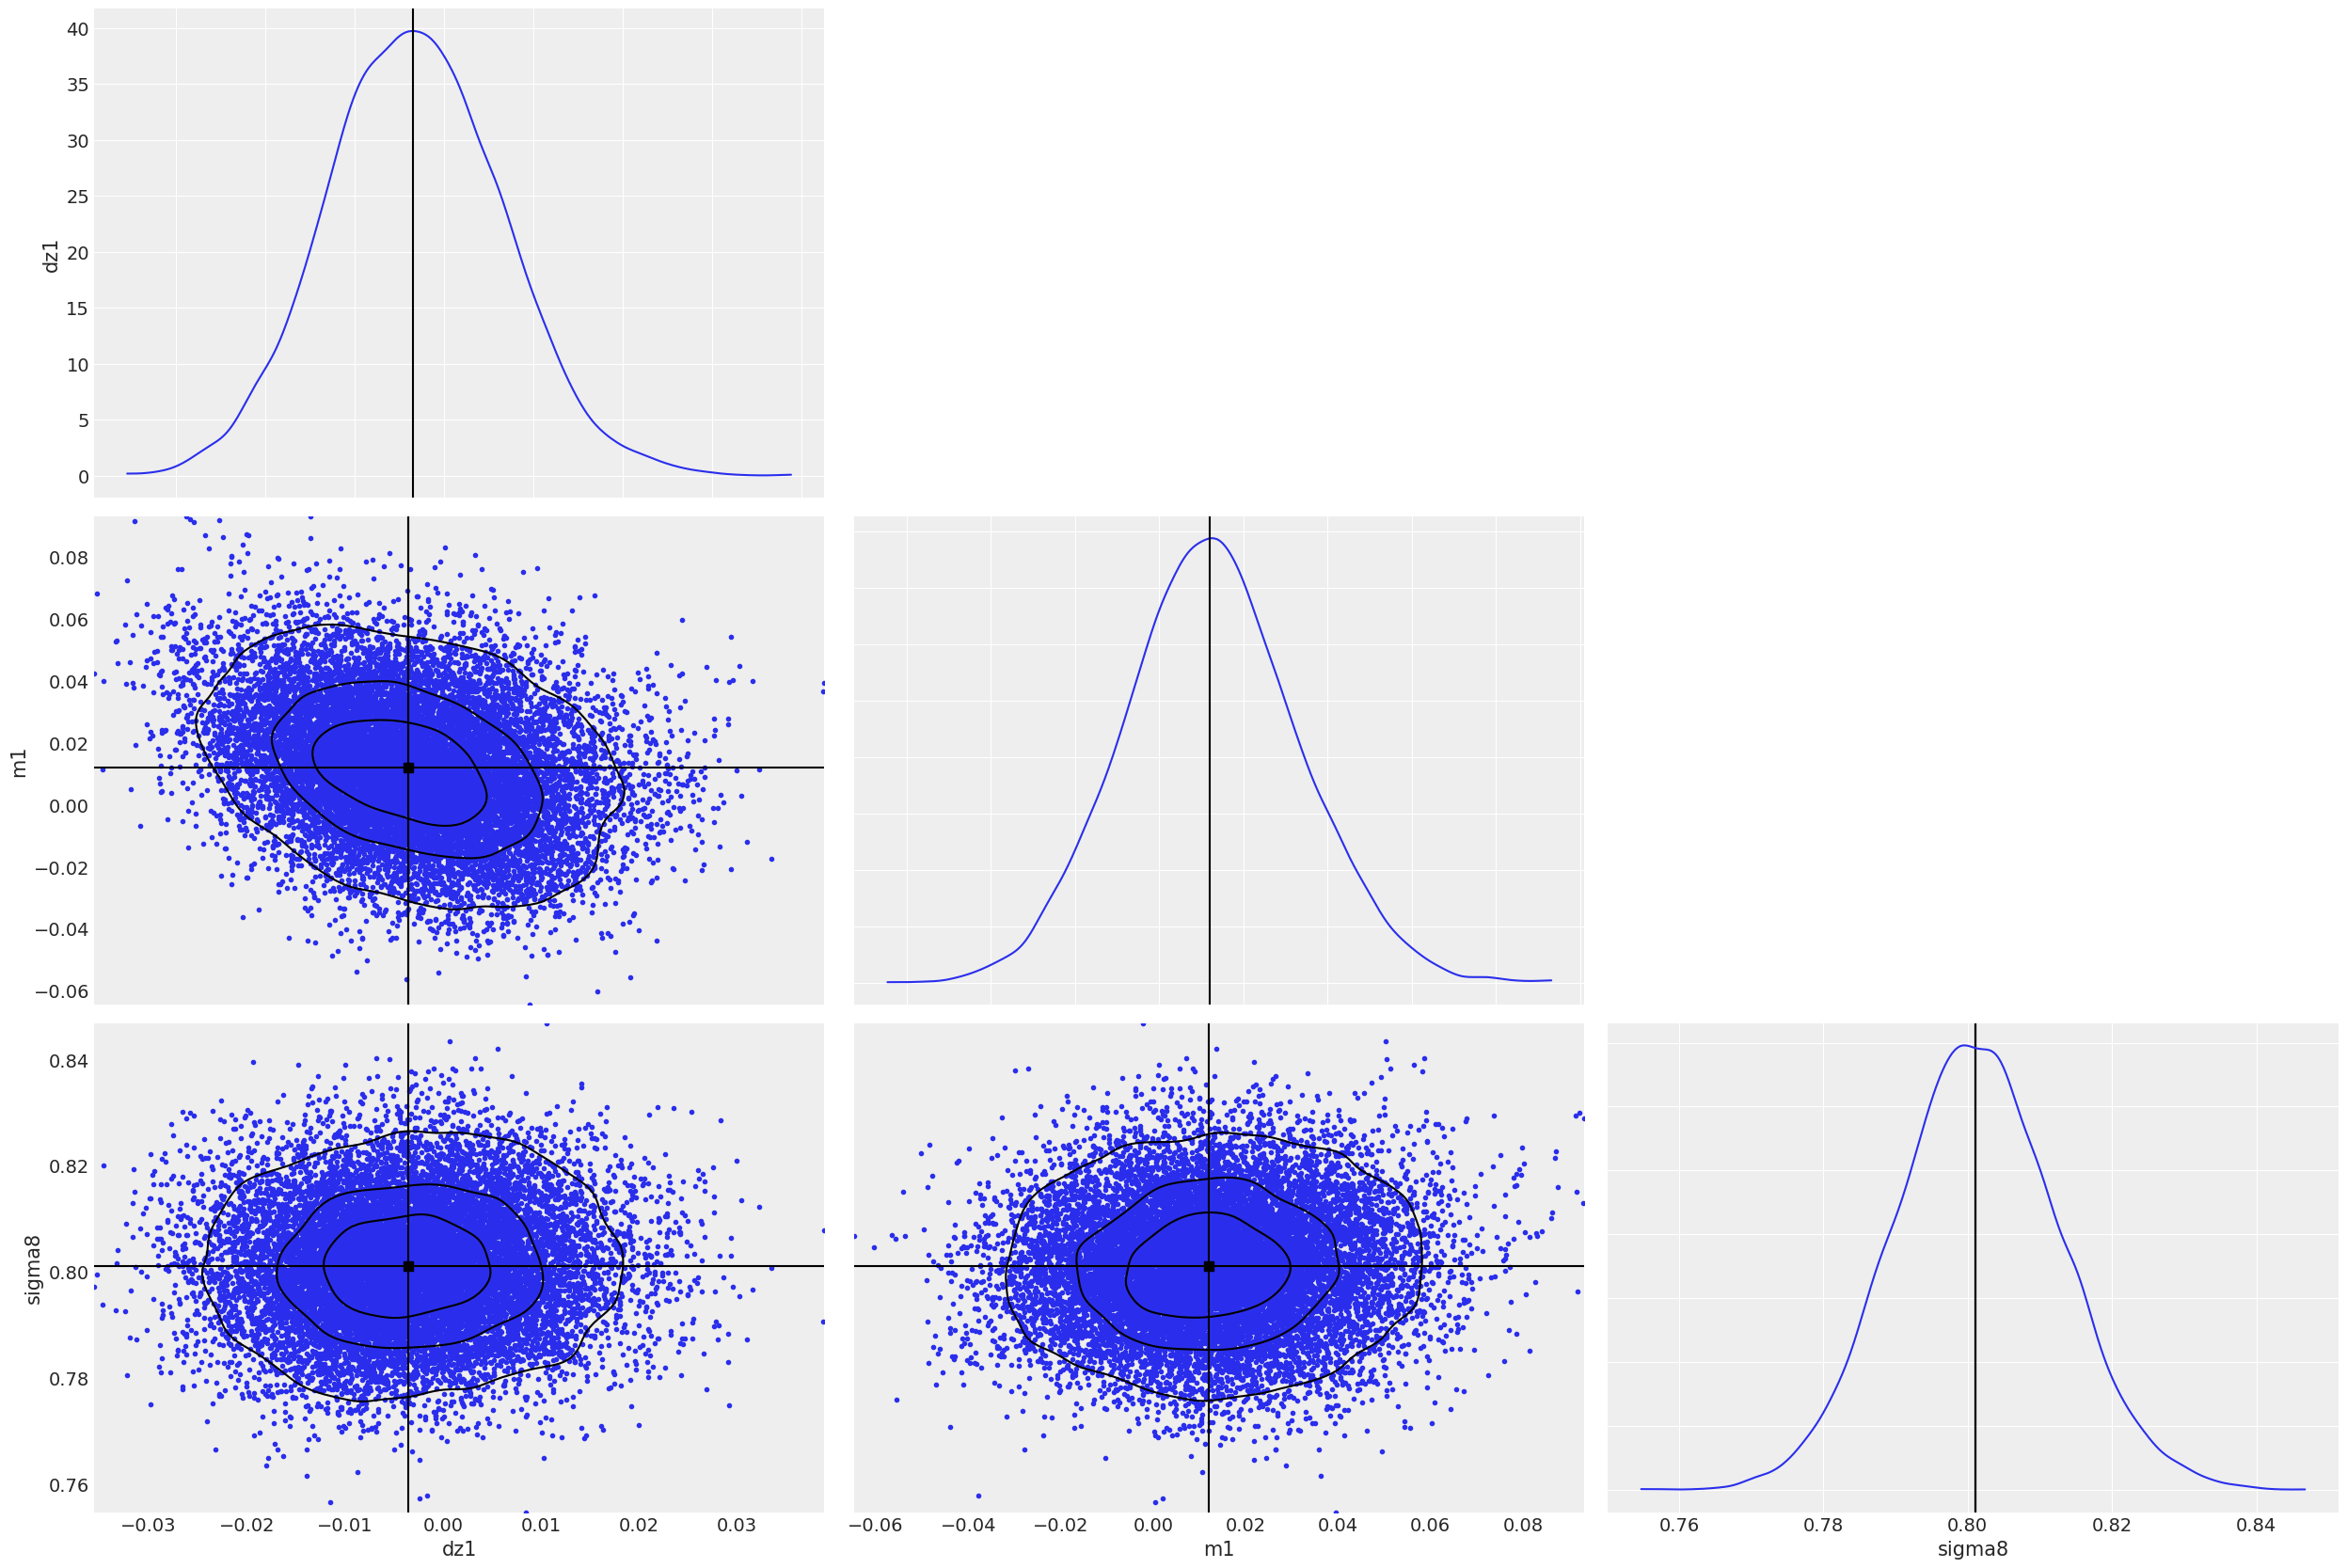

In [29]:
import arviz as az

az.style.use("arviz-darkgrid")

az.plot_pair(
    s,
    kind=["scatter", "kde"],
    var_names=['dz1', 'm1', 'sigma8'],
    kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Blues"},
    },
    marginals=True,
    point_estimate="median",
);

In [30]:
import numpy as onp
cob0 = onp.genfromtxt('hmc-chains/mh_cob.1.txt.gz')
cob1 = onp.genfromtxt('hmc-chains/mh_cob.2.txt.gz')
cob = onp.vstack((cob0, cob1))

names = [
"sigma8",
"Omega_c",
"Omega_b",
"h",
"n_s",
"w0",
"m1",
"m2",
"m3",
"m4",
"dz1",
"dz2",
"dz3",
"dz4",
"A",
"eta",
"bias1",
"bias2",
"bias3",
"bias4",
"bias5",
]
cob = {n: cob[:,i+2] for i,n in enumerate(names)}

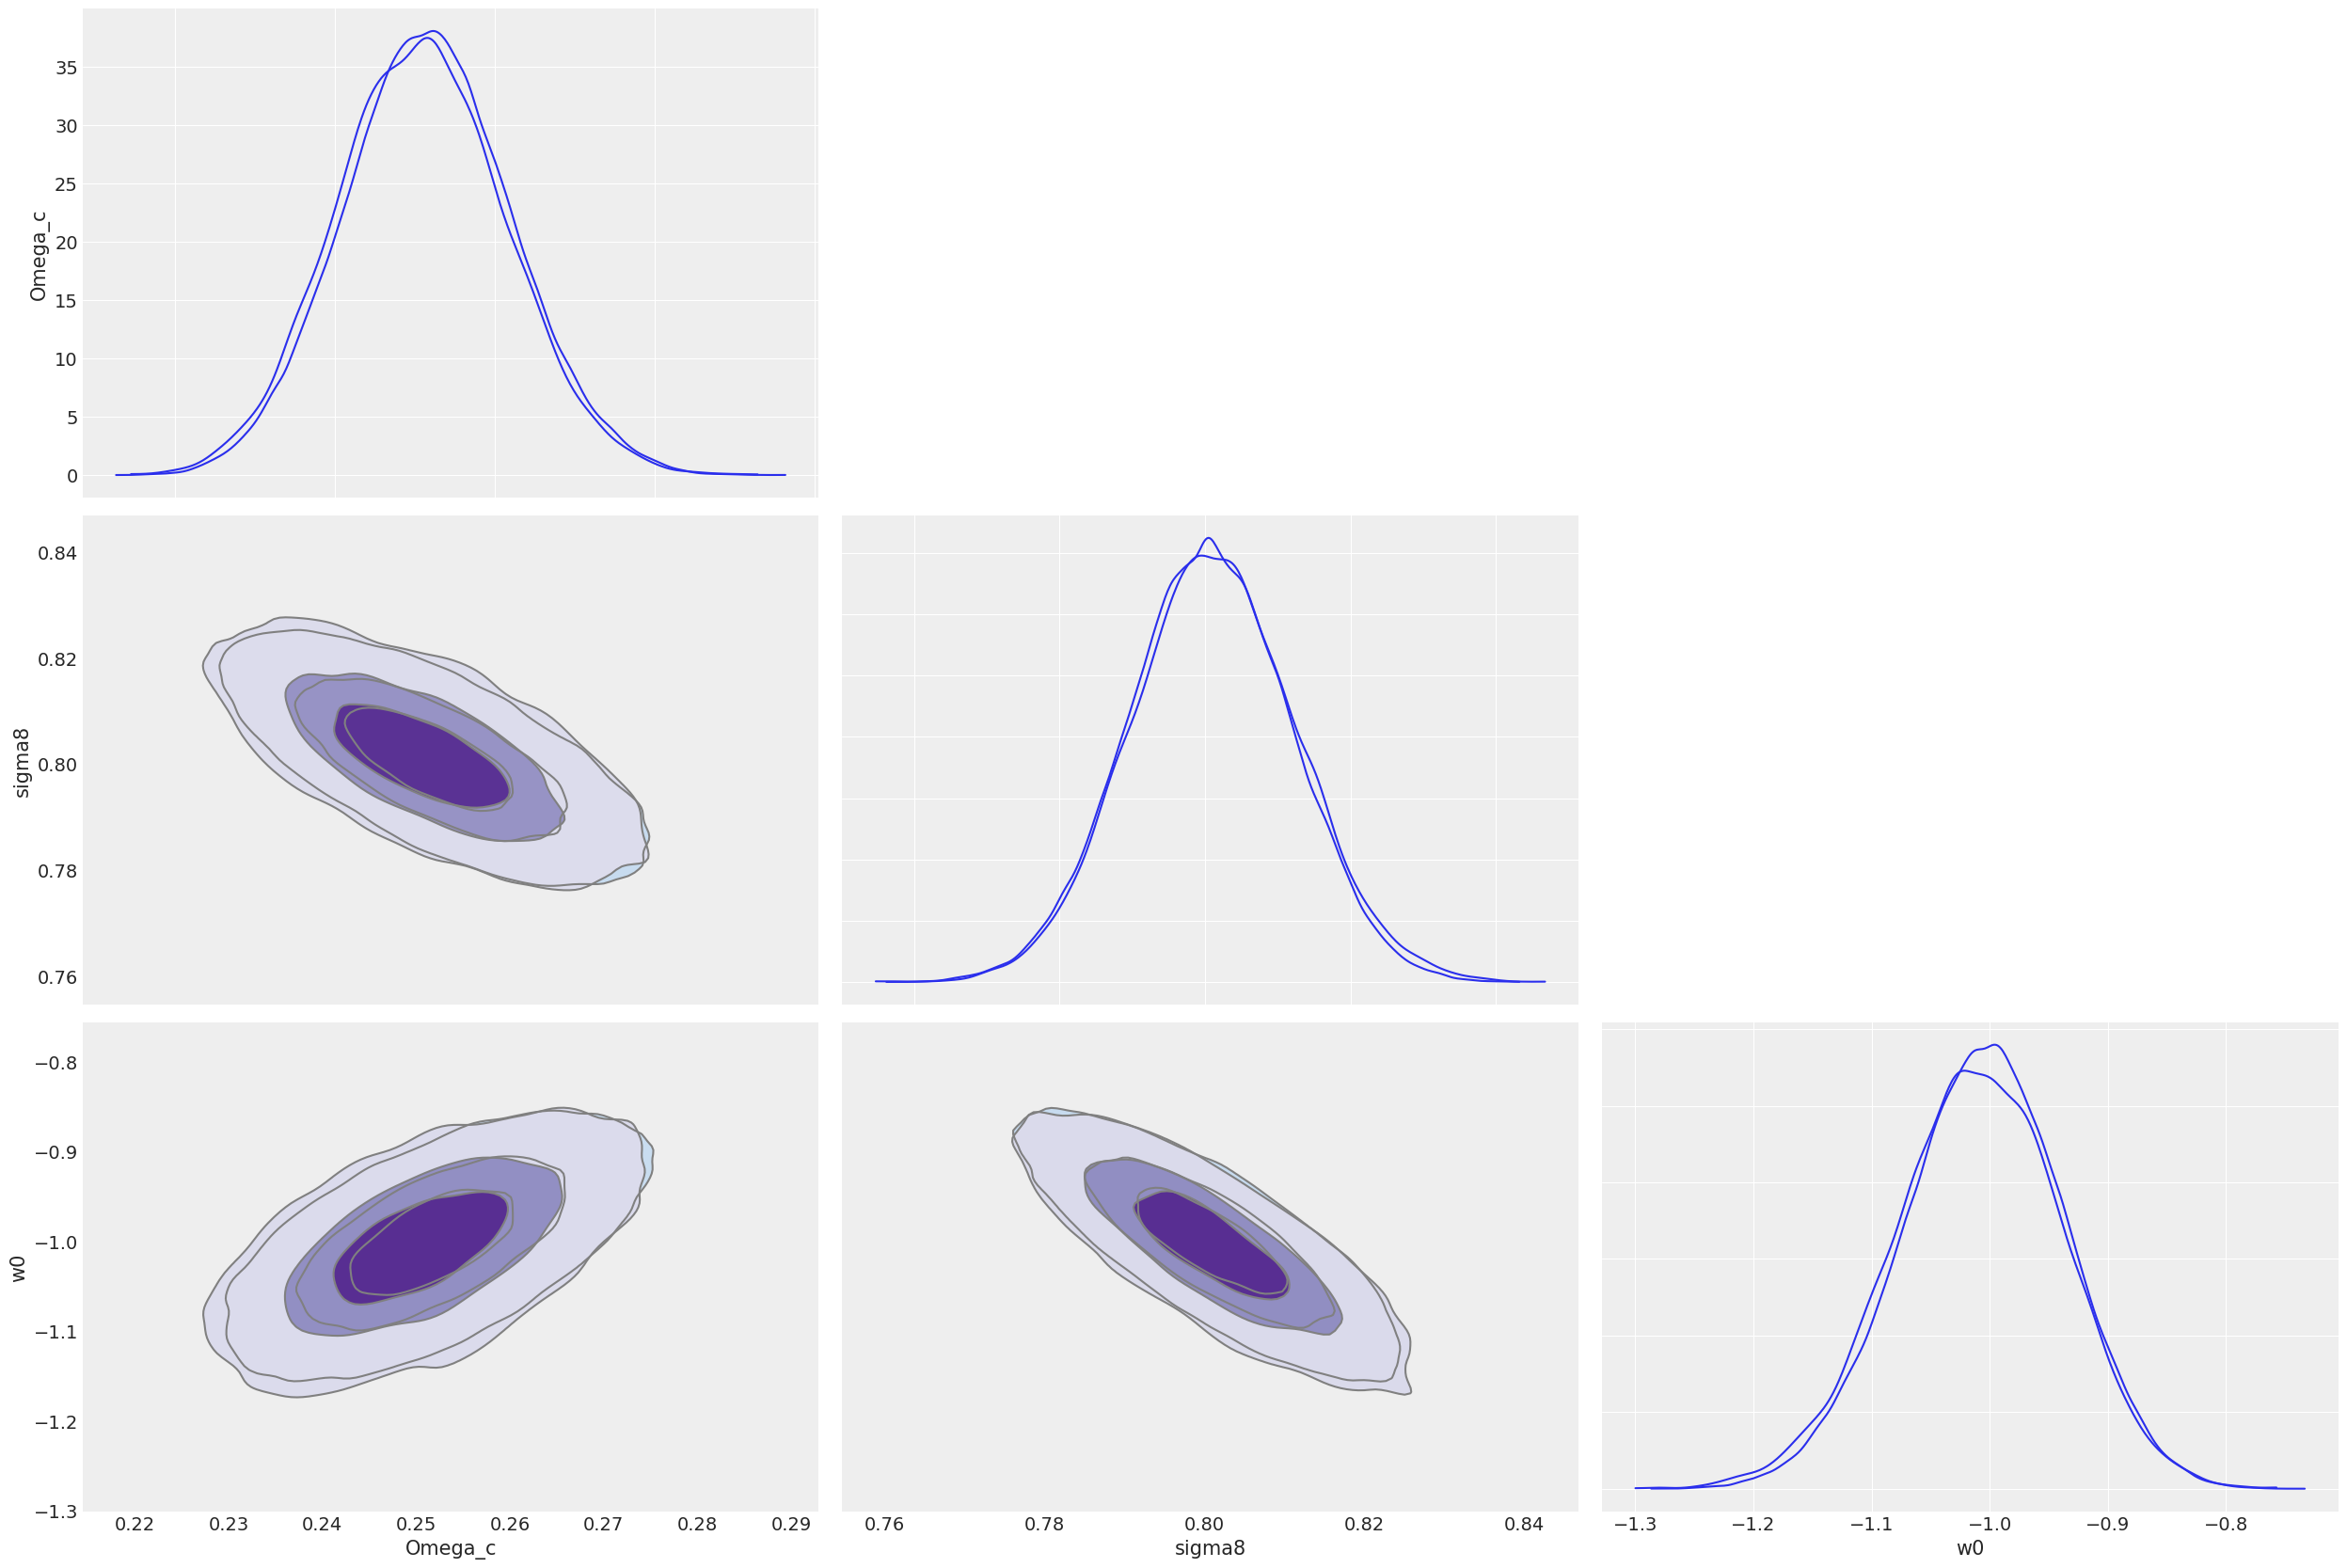

In [31]:
ax = az.plot_pair(
    cob,
    kind="kde",
    var_names=['Omega_c', 'sigma8', 'w0'],
    kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Blues"},
    },
    marginals=True,
);

az.plot_pair(
    s,
    kind="kde",
    var_names=['Omega_c', 'sigma8', 'w0'],
    kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Purples"},
    },
    marginals=True,
    ax = ax
);

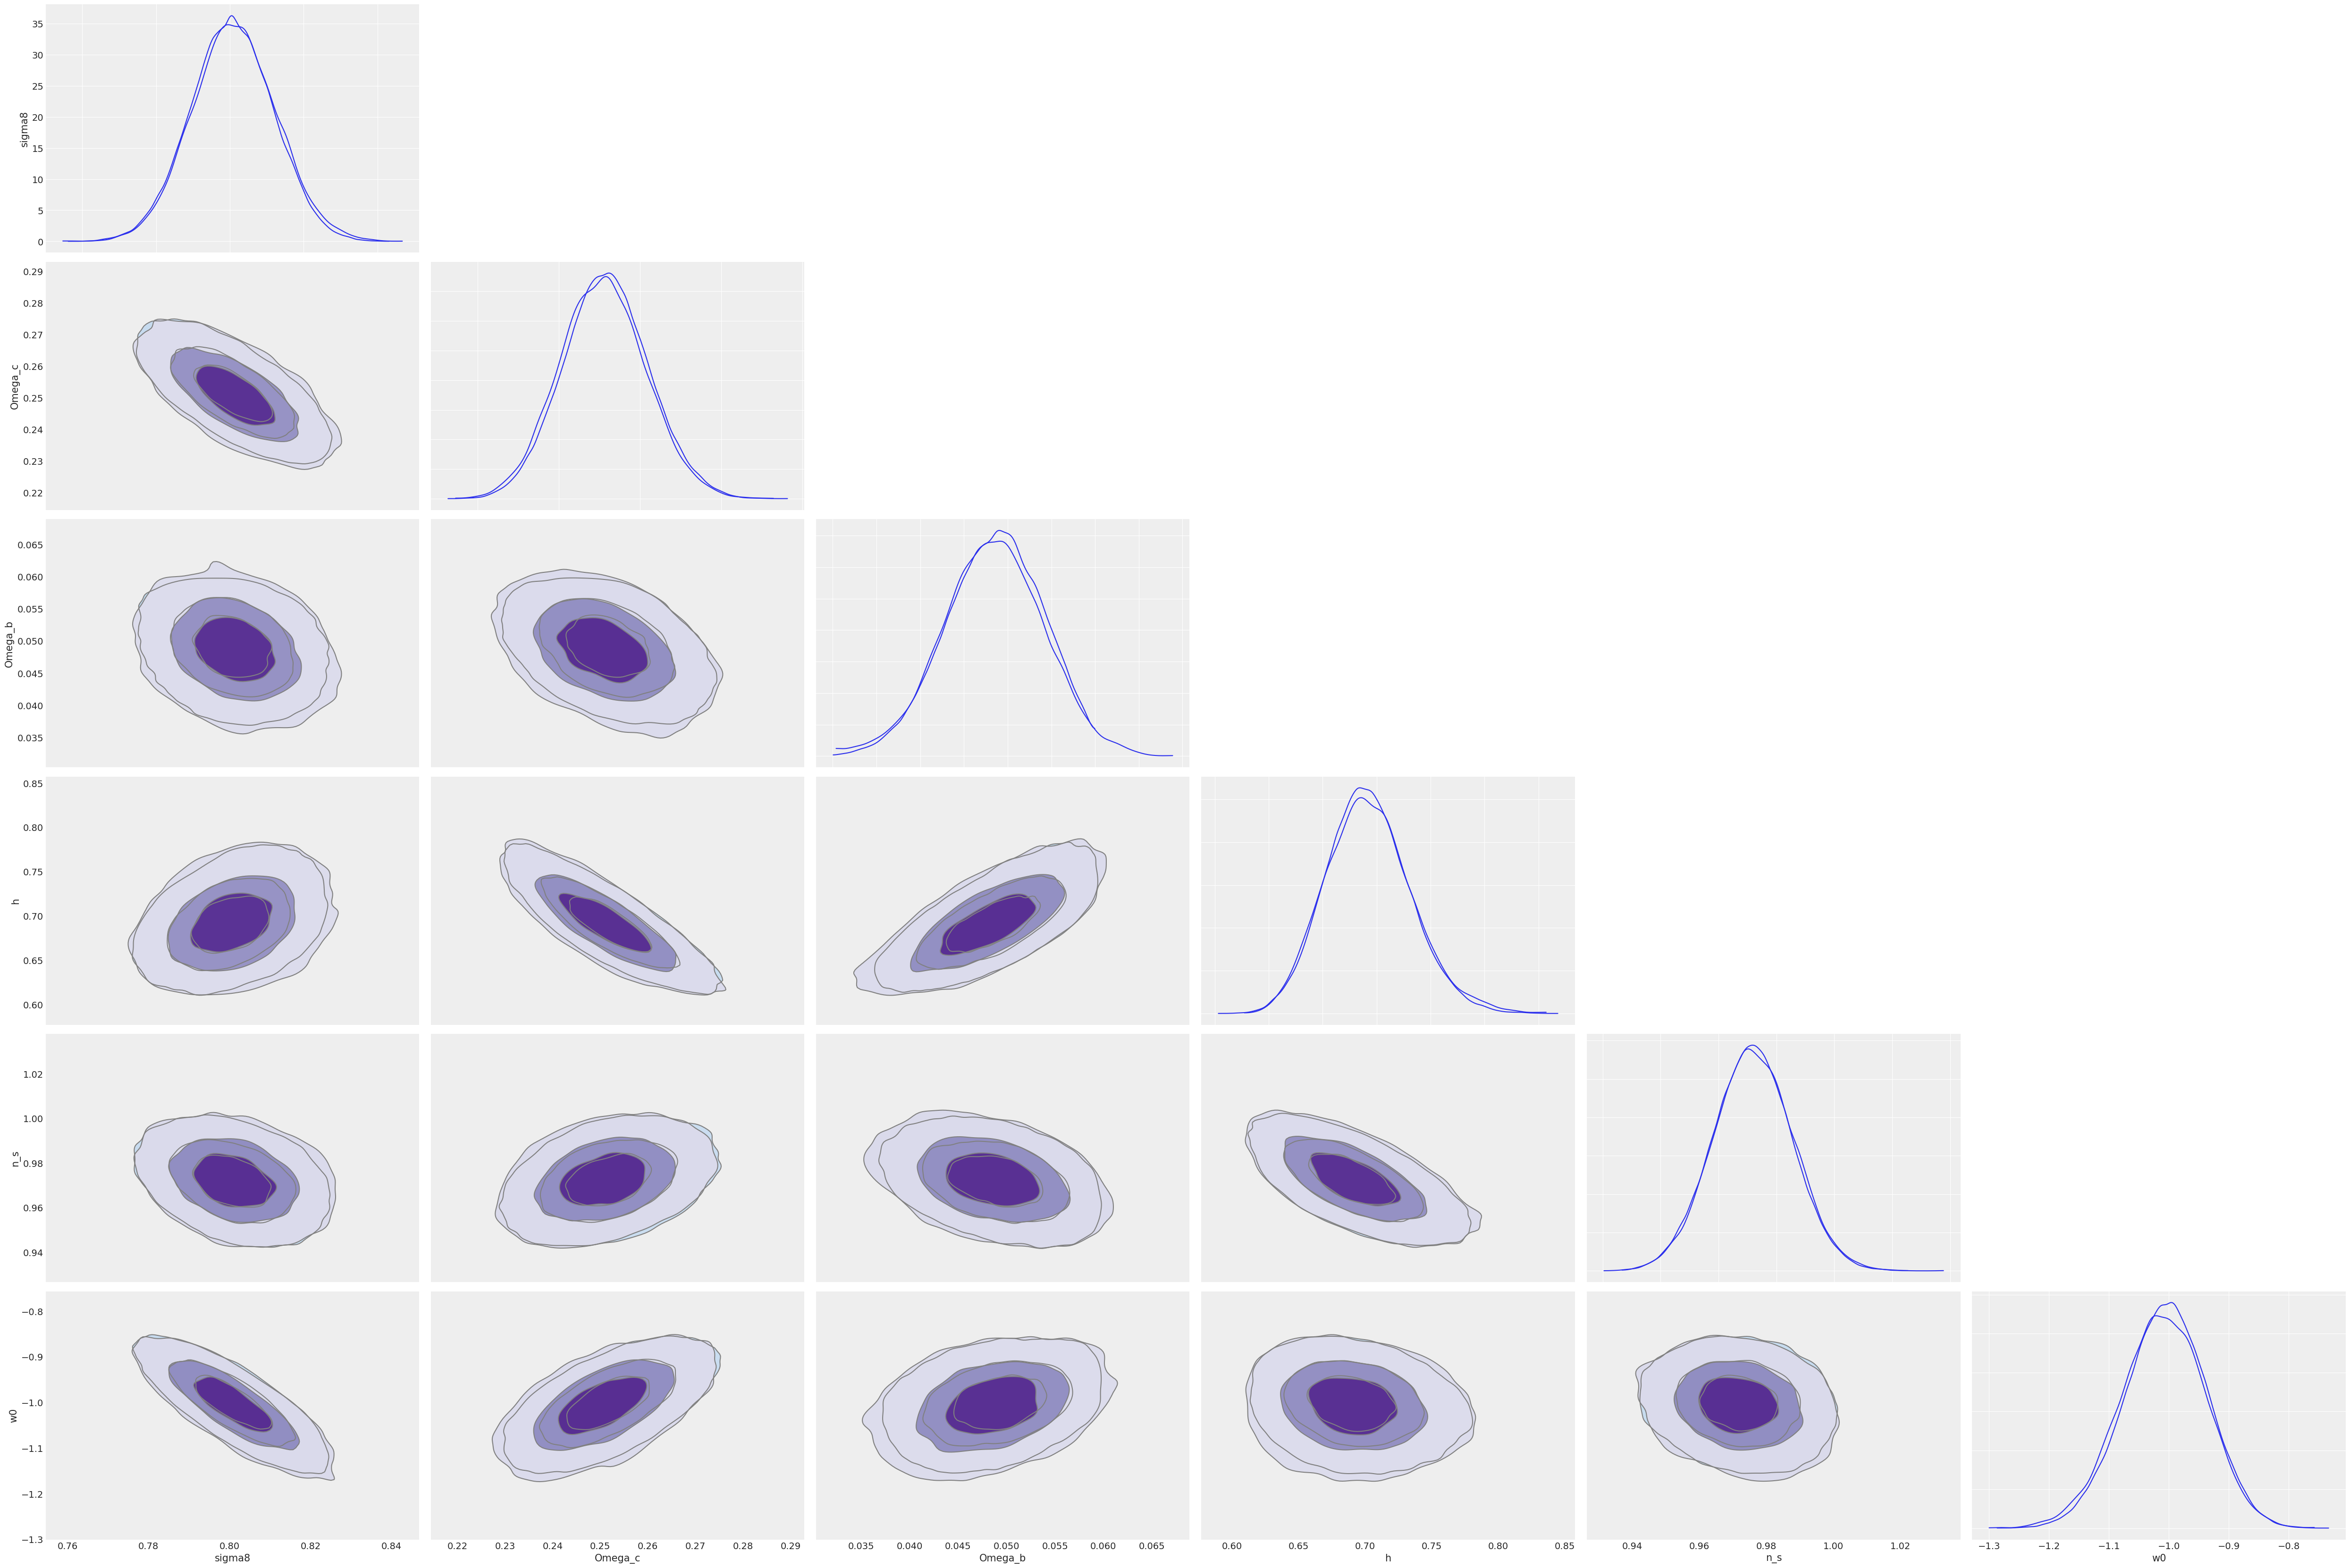

In [32]:
ax = az.plot_pair(
    cob,
    kind="kde",
        var_names=["sigma8",
"Omega_c",
"Omega_b",
"h",
"n_s",
"w0",],
    kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Blues"},
    },
    marginals=True,
);

az.plot_pair(
    s,
    kind="kde",
    var_names=["sigma8",
"Omega_c",
"Omega_b",
"h",
"n_s",
"w0",],
    kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Purples"},
    },
    marginals=True,
    ax = ax
);

In [36]:
az.ess(cob, relative=True)

<xarray.Dataset>
Dimensions:  ()
Data variables: (12/21)
    sigma8   float64 0.02919
    Omega_c  float64 0.02551
    Omega_b  float64 0.03155
    h        float64 0.02614
    n_s      float64 0.03078
    w0       float64 0.02942
    ...       ...
    eta      float64 0.02812
    bias1    float64 0.02968
    bias2    float64 0.03096
    bias3    float64 0.03147
    bias4    float64 0.03171
    bias5    float64 0.03139

In [35]:
az.ess(s, relative=True)

<xarray.Dataset>
Dimensions:         ()
Data variables: (12/42)
    A               float64 0.1063
    A_base          float64 0.1063
    Omega_b         float64 0.01392
    Omega_b_base    float64 0.01392
    Omega_c         float64 0.03651
    Omega_c_base    float64 0.03651
    ...              ...
    n_s             float64 0.05074
    n_s_base        float64 0.05074
    sigma8          float64 0.03064
    sigma8_base     float64 0.03064
    w0              float64 0.0356
    w0_base         float64 0.0356